In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
from scipy.special import expit
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import mode
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
import wandb
from sklearn.model_selection import KFold


In [4]:
class MyDecisionTreeRegressor:
    def __init__(self, **kwargs):
        self.model = DecisionTreeRegressor(**kwargs)
        self.confidence_metric = None

    def fit(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def compute_metrics(self,X_val,y_val):
        predictions_val = self.model.predict(X_val)
        mse_val = mean_squared_error(y_val, predictions_val)
        # Confidence metric is the inverse of MSE on validation data (higher confidence for lower MSE)
        self.confidence_metric = 1 / (1 + mse_val)
        confidence_metric = self.confidence_metric
        return mse_val,confidence_metric

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions
    
    def plot_predictions_vs_actual(self,predictions, actual, title="Predictions vs Actual"):
        plt.figure(figsize=(10, 6))
        plt.plot(predictions, label='Predictions', marker='o')
        plt.plot(actual, label='Actual', marker='x')
        plt.title(title)
        plt.xlabel('Sample Index')
        plt.ylabel('Values')
        plt.legend()
        plt.show()



In [5]:
class AdaBoostRegressor:
    
    def __init__ (self, num_estimators,f):
        self.num_est = num_estimators
        self.train_fraction = f
        self.models = []
        self.betas = []
        
    def initialize_weights(self, X_train):
        num_samples = X_train.shape[0]
        self.weights = np.ones(num_samples)
        self.weights = self.weights / num_samples
        
    def get_sampled_train_data(self, X_train,y_train, f):
        num_samples = int(X_train.shape[0] * f)
        self.weights = np.squeeze(self.weights)

        # Randomly choose indices based on the probability distribution
        chosen_indices = np.random.choice(X_train.shape[0], size=num_samples, replace=True, p=self.weights/np.sum(self.weights))

        # Extract the corresponding samples from X_train and y_train
        X = X_train[chosen_indices]
        y = y_train[chosen_indices]
        return X,y
    
    def update_weights(self,beta,obs_error):
        adjusted_weights = np.copy(self.weights)
        adjusted_weights = adjusted_weights*(beta**(1-obs_error))
        self.weights = adjusted_weights/np.sum(adjusted_weights)


    def weighted_median(self,values, weights):
        sorted_indices = values.argsort()
        values = values[sorted_indices]
        weights = weights[sorted_indices]
        weights_cumulative_sum = weights.cumsum()
        median_weight = np.argmax(weights_cumulative_sum >= sum(weights)/2)
        return values[median_weight]


    def fit(self, X_train, y_train):
        
        self.initialize_weights(X_train)
        
        for i in range(self.num_est):
            dt = MyDecisionTreeRegressor(max_depth=2)
            X,y = self.get_sampled_train_data(X_train, y_train, self.train_fraction)
            dt.fit(X,y)
            y_pred = dt.predict(X_train)
            self.models.append(dt)
            
            y_pred = y_pred.reshape(-1,1)
            
            obs_error = np.abs(y_train-y_pred)
            obs_error = obs_error/np.max(obs_error)

            model_error = np.sum(obs_error*self.weights)
            # print('model error : ',model_error)
            # if model_error>=0.5:
            #     print('breaking early!')
            #     self.num_est = i-1
            #     self.models = self.models[:i-1]
            #     break
            
            self.weights = self.weights.reshape(-1,1)
            beta = model_error/(1-obs_error+1e-8)
            self.betas.append(beta)
            self.update_weights(beta,obs_error)
        
        self.model_weights = np.log(1/(np.array(self.betas)+1e-8))
        
    def regress(self, X_test):
        N_test = len(X_test)
        y_pred = np.empty((N_test, self.num_est))
        for i, model in enumerate(self.models):
            y_pred[:,i] = model.predict(X_test)
            
        return np.array([self.weighted_median(y_pred[n], self.model_weights) for n in range(N_test)]) 

            

In [6]:
dataset_path = './HousingData.csv'
df = pd.read_csv(dataset_path)

Y = df.iloc[:, -1].values.reshape(-1, 1)
X = df.iloc[:, :-1].values

# finding nan values in the data and replacing by 0
X = np.nan_to_num(X, nan=0)
mean_values = np.mean(X, axis=0)
std_dev_values = np.std(X, axis=0)

# Perform Z-score normalization
X = (X - mean_values) / std_dev_values

print('number of samples  : ',X.shape[0])
print('number of features : ',X.shape[1])

f=0.8 # train fraction
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=1-f, random_state=42)
# then splitting the remaining data into val and test (50% each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


number of samples  :  506
number of features :  13


In [7]:
adb = AdaBoostRegressor(num_estimators=5,f=0.7)
adb.fit(X_train,y_train)

In [8]:
predicted = adb.regress(X_test)
print('predicted : ',predicted)
print('actual : ',np.squeeze(y_test))

predicted :  [14.19512195 22.16461538 22.16461538 22.16461538 44.15384615 14.12051282
 22.16461538 14.12051282 14.12051282 22.16461538 44.15384615 22.16461538
 14.12051282 22.16461538 22.16461538 14.12051282 14.12051282 22.16461538
 14.12051282 22.16461538 22.16461538 22.16461538 14.12051282 22.16461538
 22.16461538 14.12051282 31.51702128 22.16461538 22.16461538 14.19512195
 22.16461538 14.12051282 22.16461538 22.16461538 14.12051282 22.16461538
 22.16461538 14.12051282 14.12051282 14.12051282 14.12051282 14.12051282
 14.12051282 14.12051282 22.16461538 14.12051282 14.12051282 14.12051282
 14.12051282 14.12051282 44.15384615]
actual :  [23.1 24.8 31.5 24.2 50.  19.7 23.2 15.1 21.5 23.6 50.  23.8 17.9 29.
 20.1 16.1  7.  20.8  7.  20.3 22.5 26.5 12.7 30.8 22.6  9.6 29.8 20.6
 23.4 16.8 19.4 18.9 21.4 21.2 21.7 24.1 20.  10.9 20.  19.4 18.8 10.4
 19.1 14.  17.4 10.8 14.9 14.1  9.7 13.8 48.5]


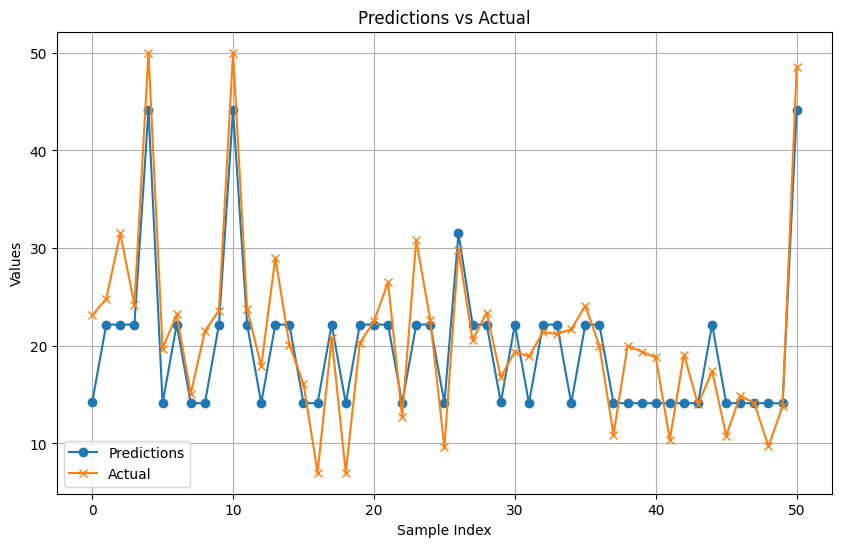

MSE  :  18.59046994966864
Root MSE  :  4.311666725254706
T-squared  :  0.7758938011361537


In [9]:
plt.figure(figsize=(10, 6))
plt.plot(predicted, label='Predictions', marker='o')
plt.plot(y_test, label='Actual', marker='x')
plt.title("Predictions vs Actual")
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

mse = mean_squared_error(y_test,predicted)
rmse = np.sqrt(mse)
r_squared = r2_score(y_pred=predicted,y_true=y_test)
print('MSE  : ',mse)
print('Root MSE  : ',rmse)
print('T-squared  : ',r_squared)


### Plotting Training time and MSE vs number of estimators

In [11]:
mse_list = []
inf_time = []
num_est = []

for n in range(100):
    t1 = time.time()
    adb = AdaBoostRegressor(num_estimators=n+5,f=0.7)
    adb.fit(X_train,y_train)
    predicted = adb.regress(X_test)
    t2 = time.time()
    mse = mean_squared_error(y_test,predicted)
    num_est.append(n+5)
    mse_list.append(mse)
    inf_time.append(t2-t1)
    


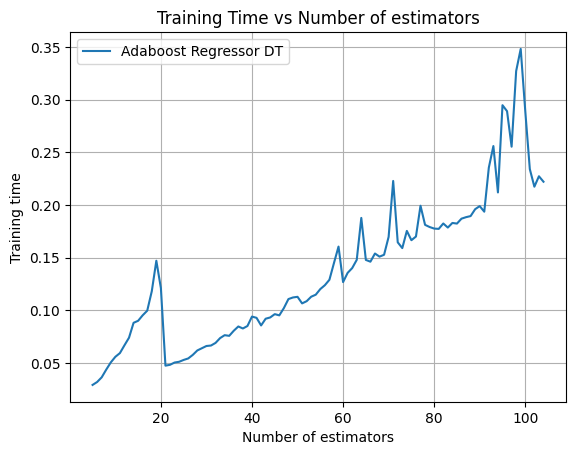

In [12]:
plt.plot(num_est, inf_time, label='Adaboost Regressor DT')
plt.xlabel('Number of estimators')
plt.ylabel('Training time')
plt.legend()
plt.grid()
plt.title('Training Time vs Number of estimators')
plt.show()

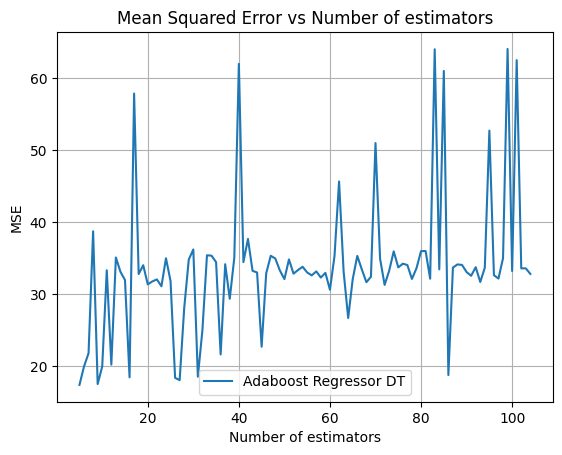

In [13]:
plt.plot(num_est, mse_list, label='Adaboost Regressor DT')
plt.xlabel('Number of estimators')
plt.ylabel('MSE')
plt.legend()
plt.grid()
plt.title('Mean Squared Error vs Number of estimators')
plt.show()